# Integrantes

- Sergio Orellana 221122
- Rodrigo Mansilla 22611
- Carlos Valladares 221164


# Ejercicio 1

## Simulación de tiempo discreto (síncrona) vs. tiempo continuo (asíncrona)

- **Tiempo discreto (síncrona)**: yo actualizo el estado del sistema en pasos fijos (ticks) con un reloj global, de modo que todos los componentes se actualizan “a la vez” en cada paso. Esto es análogo a trabajar con señales muestreadas y diferencia-ecuaciones en control digital.

- **Tiempo continuo (asíncrona)**: yo permito cambios en cualquier instante real; típicamente lo implemento como simulación dirigida por eventos que “salta” al próximo evento en una cola de eventos, sin pasos fijos. (En marcos como SimPy, los procesos se programan con env.timeout y el motor avanza al siguiente evento).

**(a) ¿Cuándo prefiero cada una?**
Prefiero tiempo discreto (síncrona) cuando:

- El fenómeno ya está muestreado por naturaleza (p. ej., control digital, DSP, comunicaciones digitales).
- Necesito simplicidad y determinismo (flujo secuencial más fácil de razonar y depurar).

Prefiero tiempo continuo (asíncrona) cuando:

- El timing exacto de los sucesos importa (colas/redes, tráfico, servicios), porque el motor salta entre eventos sin simular “tiempo vacío”.
- Busco escala y capacidad de respuesta en sistemas dirigidos por eventos o procesamiento asíncrono.

**(b) Compensaciones computacionales (velocidad vs. precisión)**

- **Discreto/síncrona:** suele ser más rápida por implementación y más simple de depurar, pero su precisión depende del tamaño del paso (riesgo de aliasing/artefactos si el paso es grande).
- **Continuo/asíncrona:** logra mejor precisión temporal (eventos en el instante exacto) y puede ser eficiente al evitar pasos donde nada ocurre; a cambio, incrementa la complejidad (concurrencia, manejo de callbacks/eventos, depuración).


## Mecanismos de gestión de eventos

**(a) ¿Cómo gestionan los cambios de estado las colas de eventos?**

Cuando modelo de forma asíncrona, mantengo una cola de eventos con elementos del tipo (tiempo, tipo, datos). El ciclo de simulación hace:

- Extraer el siguiente evento (el de menor marca de tiempo).
- Avanzar el reloj de simulación a ese instante.
- Aplicar las transiciones de estado y programar nuevos eventos (insertarlos en la cola).

Este patrón aparece tanto en frameworks de simulación (p. ej., SimPy con procesos/env.timeout) como en bucles de eventos (JS: el event loop despacha tareas desde la event queue cuando la pila está libre).

En arquitectura de sistemas, las message queues/colas de mensajes permiten desacoplar productores y consumidores de eventos, reforzando la idea de que los cambios de estado se encolan y se procesan sin bloquear el flujo principal

**(b) Gestión de prioridades para eventos concurrentes**

Para resolver eventos “al mismo tiempo” o con diferentes importancias, utilizo una cola de prioridad (típicamente un binary heap), donde sale primero el evento de mayor prioridad (o menor tiempo y, si hay empates, un criterio secundario). Las operaciones de insertar y extraer tienen costo O(log n), lo que mantiene eficiente el motor de simulación. Además, las simulaciones dirigidas por eventos son un caso de uso clásico de colas de prioridad.

Como ejemplo de priorización de colas en un bucle de eventos, en JavaScript existen microtareas que se procesan antes de las tareas normales, mostrando cómo la política de prioridad afecta qué se ejecuta primero cuando hay concurrencia.


R_eff (discreto): 2.706
R_eff (eventos):  2.000


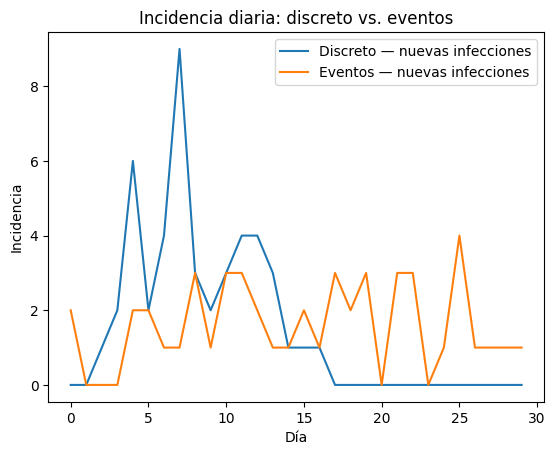

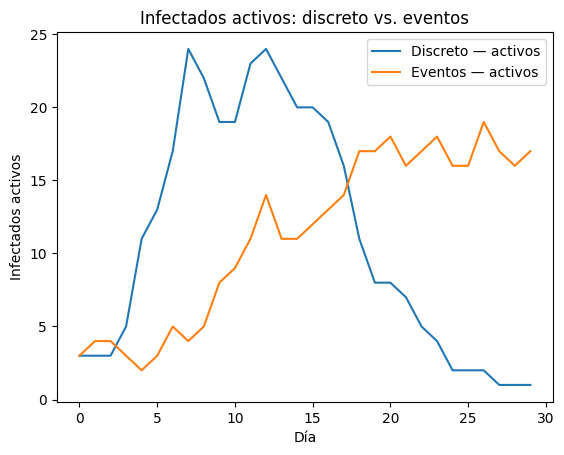

In [ ]:
import math
import random
import heapq
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# Utilidades


def poisson_knuth(lam: float) -> int:
    """Muestreo de Poisson con el algoritmo de Knuth (adecuado para lambda pequeña-media)."""
    if lam <= 0:
        return 0
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        p *= random.random()
    return k - 1


def expovariate_safe(rate: float) -> float:
    """Devuelve tiempo de espera exponencial con media 1/rate; maneja rate=0."""
    if rate <= 0:
        return float("inf")
    return random.expovariate(rate)


# Dominio
@dataclass
class Agent:
    id: int
    role: str  # 'patient' o 'staff'
    ward: int  # sala (0,1, ...)
    state: str = "S"  # 'S','I','R'
    infected_by: Optional[int] = None
    inf_time: Optional[float] = None
    rec_time: Optional[float] = None
    mask: float = 0.6  # [0,1] (1 = máxima adherencia)
    hygiene: float = 0.6  # [0,1]
    immunity: float = 0.0  # [0,1] (1 = completamente inmune)


class Params:
    """
    Parámetros del hospital y de la enfermedad.
    """

    def __init__(self):
        # Estructura
        self.wards = [0, 1]  # dos salas
        self.n_patients = 50
        self.n_staff = 10

        # Enfermedad
        self.beta = 0.06  # prob. base de transmisión por contacto
        self.mask_eff = (
            0.35  # reducción fraccional por uso de mascarilla (por cada lado)
        )
        self.hygiene_eff = 0.25  # reducción fraccional por higiene promedio
        self.inf_mean_days = 7.0  # duración media infecciosa (días)

        # Contactos esperados por día
        self.c_rate_patient = 6.0
        self.c_rate_staff = 12.0

        # Movimiento entre salas
        self.move_rate_per_day = 0.02

        # Discreto
        self.days = 30

        # Dirigido por eventos
        self.horizon_days = 30.0
        self.max_events = 100_000


def transmission_prob(p: Params, a: Agent, b: Agent) -> float:
    """
    Probabilidad efectiva de transmisión en un contacto a->b.
    Incluye efectos de mascarilla, higiene e inmunidad (susceptibilidad).
    """
    mask_mult = (1 - p.mask_eff * a.mask) * (1 - p.mask_eff * b.mask)
    hygiene_mult = 1 - p.hygiene_eff * (a.hygiene + b.hygiene) / 2.0
    susceptibility_mult = 1 - b.immunity
    pr = p.beta * mask_mult * hygiene_mult * susceptibility_mult
    return max(0.0, min(1.0, pr))


def sample_infectious_duration(p: Params) -> float:
    """Muestra una duración infecciosa ~ Exponencial(media = p.inf_mean_days)."""
    return random.expovariate(1.0 / p.inf_mean_days)


def init_agents(p: Params, rng_seed: Optional[int] = None) -> List[Agent]:
    """
    Inicializa pacientes y personal con heterogeneidad en adherencia e inmunidad.
    Si rng_seed no es None, siembra aleatoriedad para reproducibilidad.
    """
    if rng_seed is not None:
        random.seed(rng_seed)

    agents: List[Agent] = []

    # Pacientes
    for i in range(p.n_patients):
        agents.append(
            Agent(
                id=i,
                role="patient",
                ward=random.choice(p.wards),
                mask=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
                hygiene=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
                immunity=max(0.0, random.gauss(0.05, 0.05)),
            )
        )

    # Personal
    for j in range(p.n_staff):
        agents.append(
            Agent(
                id=p.n_patients + j,
                role="staff",
                ward=random.choice(p.wards),
                mask=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
                hygiene=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
                immunity=max(0.0, random.gauss(0.10, 0.05)),
            )
        )

    # Semilla de infecciones iniciales
    seed_ids = random.sample(range(len(agents)), k=3)
    for sid in seed_ids:
        a = agents[sid]
        a.state = "I"
        a.inf_time = 0.0
        a.rec_time = sample_infectious_duration(p)

    return agents


# Arquitectura 1: tiempo discreto


def run_discrete(p: Params, seed: int = 123) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}  # número de secundarios por infectante

    daily_incidence: List[int] = []
    daily_active: List[int] = []

    for day in range(p.days):
        new_inf = 0

        # Recuperaciones al inicio del día
        for a in agents:
            if a.state == "I" and a.rec_time is not None and a.rec_time <= day:
                a.state = "R"

        # Índice por sala
        ward_index: Dict[int, List[Agent]] = {w: [] for w in p.wards}
        for a in agents:
            ward_index[a.ward].append(a)

        # Contactos
        for a in agents:
            lam = p.c_rate_patient if a.role == "patient" else p.c_rate_staff
            k = poisson_knuth(lam)
            if k <= 0:
                continue

            peers = ward_index[a.ward]
            if len(peers) <= 1:
                continue

            for _ in range(k):
                b = random.choice(peers)
                if b.id == a.id:
                    continue

                # Intentar transmisión en ambos sentidos
                if a.state == "I" and b.state == "S":
                    pr = transmission_prob(p, a, b)
                    if random.random() < pr:
                        b.state = "I"
                        b.inf_time = float(day)
                        b.rec_time = day + sample_infectious_duration(p)
                        b.infected_by = a.id
                        offspring[a.id] += 1
                        new_inf += 1

                elif b.state == "I" and a.state == "S":
                    pr = transmission_prob(p, b, a)
                    if random.random() < pr:
                        a.state = "I"
                        a.inf_time = float(day)
                        a.rec_time = day + sample_infectious_duration(p)
                        a.infected_by = b.id
                        offspring[b.id] += 1
                        new_inf += 1

        # Movimiento
        for a in agents:
            if random.random() < p.move_rate_per_day:
                a.ward = 1 - a.ward

        # Métricas
        active = sum(1 for a in agents if a.state == "I")
        daily_incidence.append(new_inf)
        daily_active.append(active)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for x in offspring.values() if x > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame(
        {
            "day": list(range(p.days)),
            "new_infections": daily_incidence,
            "active_infected": daily_active,
        }
    )
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring


# Arquitectura 2: dirigida por eventos
def run_event_driven(p: Params, seed: int = 456) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}

    # Cola de eventos: (time, seq, type, agent_id, payload)
    q: List[Tuple[float, int, str, int, dict]] = []
    seq = 0

    def schedule(time: float, typ: str, aid: int, payload: dict = None):
        nonlocal seq
        heapq.heappush(q, (time, seq, typ, aid, payload or {}))
        seq += 1

    def contact_rate(a: Agent) -> float:
        return p.c_rate_patient if a.role == "patient" else p.c_rate_staff

    # Inicialización: primer contacto y movimiento de cada agente; recuperaciones para infectados
    for a in agents:
        schedule(expovariate_safe(contact_rate(a)), "contact", a.id)
        schedule(expovariate_safe(p.move_rate_per_day), "move", a.id)
        if a.state == "I":
            schedule(sample_infectious_duration(p), "recovery", a.id)

    infection_times: List[float] = []
    recovery_times: List[float] = []

    events_processed = 0
    while q and events_processed < p.max_events:
        t, _, typ, aid, payload = heapq.heappop(q)
        if t > p.horizon_days:
            break
        a = agents[aid]

        if typ == "contact":
            # Reprogramar siguiente contacto de este agente
            schedule(t + expovariate_safe(contact_rate(a)), "contact", a.id)

            # Elegir contraparte en la misma sala
            peers = [x for x in agents if x.ward == a.ward and x.id != a.id]
            if peers:
                b = random.choice(peers)

                # Intentar transmisión en ambos sentidos
                def try_transmit(src: Agent, dst: Agent):
                    nonlocal infection_times
                    if src.state == "I" and dst.state == "S":
                        pr = transmission_prob(p, src, dst)
                        if random.random() < pr:
                            dst.state = "I"
                            dst.inf_time = t
                            dur = sample_infectious_duration(p)
                            dst.rec_time = t + dur
                            dst.infected_by = src.id
                            offspring[src.id] += 1
                            infection_times.append(t)
                            # Programar recuperación del nuevo infectado
                            schedule(dst.rec_time, "recovery", dst.id)

                try_transmit(a, b)
                try_transmit(b, a)

        elif typ == "recovery":
            if a.state == "I":
                a.state = "R"
                a.rec_time = t
                recovery_times.append(t)

        elif typ == "move":
            # Cambio de sala y reprogramación del próximo movimiento
            a.ward = 1 - a.ward
            schedule(t + expovariate_safe(p.move_rate_per_day), "move", a.id)

        events_processed += 1

    # Agregación diaria de métricas
    days = int(math.ceil(p.horizon_days))
    daily_incidence: List[int] = [0] * days
    for it in infection_times:
        d = int(math.floor(it))
        if 0 <= d < days:
            daily_incidence[d] += 1

    daily_active: List[int] = []
    for d in range(days):
        cnt = 0
        for ag in agents:
            if ag.inf_time is not None and ag.inf_time <= d:
                # Si rec_time es None o mayor al día actual, sigue activo
                if ag.rec_time is None or d < ag.rec_time:
                    cnt += 1
        daily_active.append(cnt)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for v in offspring.values() if v > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame(
        {
            "day": list(range(days)),
            "new_infections": daily_incidence,
            "active_infected": daily_active,
        }
    )
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring


if __name__ == "__main__":
    random.seed(42)

    p = Params()
    df_disc, off_disc = run_discrete(p, seed=101)
    df_ev, off_ev = run_event_driven(p, seed=202)

    print(f"R_eff (discreto): {df_disc.attrs.get('R_eff_estimate'):.3f}")
    print(f"R_eff (eventos):  {df_ev.attrs.get('R_eff_estimate'):.3f}")

    # Incidencia diaria
    plt.figure()
    plt.plot(
        df_disc["day"], df_disc["new_infections"], label="Discreto — nuevas infecciones"
    )
    plt.plot(
        df_ev["day"], df_ev["new_infections"], label="Eventos — nuevas infecciones"
    )
    plt.xlabel("Día")
    plt.ylabel("Incidencia")
    plt.title("Incidencia diaria: discreto vs. eventos")
    plt.legend()
    plt.show()

    # Activos diarios
    plt.figure()
    plt.plot(df_disc["day"], df_disc["active_infected"], label="Discreto — activos")
    plt.plot(df_ev["day"], df_ev["active_infected"], label="Eventos — activos")
    plt.xlabel("Día")
    plt.ylabel("Infectados activos")
    plt.title("Infectados activos: discreto vs. eventos")
    plt.legend()
    plt.show()

## Especificación (discreto)

**Reloj:** `d = 0, 1, 2, ...` (días)

**Ciclo por día:**

1. Procesar recuperaciones (`rec_time <= d`).
2. Construir índice de sala → lista de agentes.
3. Para cada agente, muestrear `#contactos ~ Poisson(c_rate_role)`.
   - Para cada contacto, elegir un par aleatorio en la misma sala y evaluar transmisión en ambos sentidos.
4. Aplicar movimiento (con probabilidad pequeña por día).
5. Medir métricas: nuevas infecciones del día e infectados activos.

**Eventos a monitorizar (implícitos por paso):**

- Contacto (potencial contagio)
- Recuperación
- Movimiento

**Métricas de salida:**

- Incidencia diaria
- Activos diarios
- R_eff (crudo)
- Descendencia por agente (número de secundarios por infectante)


## Especificación (dirigida por eventos)

**Reloj:** tiempo continuo; el simulador **salta** al tiempo del **siguiente evento**.

**Estructura de eventos:** cola de prioridad (_heap_) con tuplas  
`(time, seq, type, agent_id, payload)`.

**Tipos de eventos:**

- `contact`: un agente tiene contacto; se elige una contraparte en la misma sala y se intenta transmisión en ambos sentidos.  
  Se programa el próximo contacto del agente con espera `~ Expon(rate_contacto)`.
- `recovery`: un infectado pasa a `R`.
- `move`: cambio de sala; se reprograma el próximo movimiento `~ Expon(move_rate)`.

**Métricas de salida:**

- A partir de las marcas temporales de infecciones:
  - Incidencia diaria agregada
  - Activos diarios (conteo entre `inf_time` y `rec_time`)
  - R_eff
  - Descendencia por agente


# Teoría — Taxonomía de rasgos y espacio de parámetros

## 1) Clasificación de rasgos (discreto, continuo o relacional)

- **a) Edad → _continuo_ (escala de razón)**  
  Yo la trato como una cantidad medible sobre tiempo real; aunque a veces la discretice (en años), su naturaleza es continua.

- **b) Profesión → _discreto_ (categórico nominal)**  
  Yo la represento como una categoría sin orden intrínseco (médico, enfermero, administrativo, etc.).

- **c) Redes de amistad → _relacional_**  
  Yo las modelo como relaciones (aristas) entre agentes (nodos) en un grafo/social network; no es un atributo individual, sino una estructura de vínculos.

- **d) Estado de vacunación → _discreto_ (binario/dicotómico)**  
  Yo lo codifico como variable dicotómica (vacunado / no vacunado), un caso de variable nominal con dos niveles.

## 2) Tamaño del espacio de parámetros y efecto en el tiempo de ejecución

**Escenario:** 10 000 agentes con **3 rasgos continuos** (p. ej., tasas) y **2 rasgos discretos** (p. ej., ocupación).

### 2.1. Tamaño del espacio

- Si dejo los continuos como reales, el espacio **por agente** es **infinito**. Para poder explorarlo, yo **discretizo** cada continuo en $k$ “bins” (resolución). Con $d_1, d_2$ categorías para los dos rasgos discretos, el tamaño queda:

$$
|\Omega_{\mathrm{agente}}| \;=\; k^3 \, d_1 \, d_2
$$

$$
|\Omega_{\mathrm{total}}| \;=\; \big(k^3 \, d_1 \, d_2\big)^{10{,}000}
$$

- Este crecimiento por producto es **combinatorio** y se conecta con la **maldición de la dimensionalidad**: al aumentar dimensiones (parámetros) y resolución ($k$), la cantidad de configuraciones y muestras necesarias explota.

> **Ejemplo (ilustrativo):** si $k=100$, $d_1=10$ (ocupaciones) y $d_2=2$ (binario), entonces  
> $|\Omega_{\mathrm{agente}}| = 100^3 \cdot 10 \cdot 2 = 20{,}000{,}000$ y  
> $|\Omega_{\mathrm{total}}| = (2\times10^7)^{10{,}000}$ (astronómico).

### 2.2. Efecto en el tiempo de ejecución

- Cuando hago un **grid search** (barrido exhaustivo), el número de combinaciones escala como el **producto** de opciones por parámetro; con los continuos discretizados, yo evalúo aproximadamente

  $$
  N_{\mathrm{corridas}} \;=\; k^3 \, d_1 \, d_2,
  $$

  y cada combinación suele requerir varias corridas/semillas.

- El tiempo total de cómputo crece como $N_{\mathrm{corridas}} \times T_{\mathrm{sim}}$; aunque $T_{\mathrm{sim}}$ sea moderado, el gran $N_{\mathrm{corridas}}$ produce explosión combinatoria (otra manifestación de la maldición de la dimensionalidad).

- **Cómo lo mitigo en la práctica:** en vez de barridos exhaustivos, uso muestreos estratificados como **Latin Hypercube Sampling (LHS)** para cubrir el espacio con muchas menos corridas manteniendo buena cobertura.


### Ejercicio Práctico


In [ ]:
from dataclasses import dataclass
from typing import Optional, List


@dataclass
class UrbanAgent:
    agent_id: int
    household_id: int  # rasgo relacional
    occupation: str  # rasgo discreto
    income_bracket: str  # rasgo discreto
    vaccination_status: str  # rasgo discreto
    mobility_rate: float  # rasgo continuo (>=0)
    contact_rate: float  # rasgo continuo (>=0)
    neighbors: Optional[List[int]] = None  # red social opcional


UrbanAgent(0, 0, "teacher", "mid", "full", 1.2, 2.3)

### **¿Cómo encodeo trabajadores de la salud vs. maestros para evitar sesgo?**

Para evitar introducir un orden artificial entre categorías, yo uso one‑hot encoding para "occupation" (columnas binarias como "occ_health_worker", "occ_teacher", etc.). Evito ordinal encoding para categorías nominales. Si necesito técnicas basadas en medias (target/mean encoding), las aplico con validación estricta para prevenir fuga de objetivo y sesgos cuando hay categorías poco frecuentes.


## 2) Muestreo de distribuciones realistas y validación

### 2.1. Métodos de muestreo que propongo

- Para `mobility_rate` y `contact_rate` (positivas y sesgadas a la derecha), uso **Gamma** (o Lognormal).  
  Si quiero una media $$\mu$$ y desviación $$\sigma$$ para Gamma, determino forma y escala como:  
  $$k = (\mu/\sigma)^2, \quad \theta = \sigma^2/\mu.$$
- Para cubrir espacios de parámetros de forma eficiente, puedo usar muestreo estratificado o Latin Hypercube Sampling (LHS).

### 2.2. Generación de una población sintética mínima

_Este bloque crea una población de ejemplo con hogares, categorías y continuas Gamma; además marca turnos nocturnos para personal de salud._


In [2]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(42)
N = 10_000

# Categorías y proporciones ilustrativas
occ_categories = ["health_worker", "teacher", "retail", "office", "unemployed"]
occ_probs = [0.06, 0.08, 0.22, 0.54, 0.10]

income_categories = ["low", "mid", "high"]
income_probs = [0.35, 0.45, 0.20]

vax_categories = ["unvaccinated", "partial", "full", "boosted"]
vax_probs_low = [0.35, 0.20, 0.30, 0.15]
vax_probs_mid = [0.25, 0.20, 0.35, 0.20]
vax_probs_high = [0.10, 0.15, 0.40, 0.35]

# Hogares: tamaños ~ Poisson+1
lam_house = 2.5
sizes = rng.poisson(lam_house, size=N)
sizes = np.maximum(1, sizes)
cum = np.cumsum(sizes)
cut = np.searchsorted(cum, N)
sizes = sizes[:cut]
sizes[-1] += N - sizes.sum()
household_id = np.repeat(np.arange(len(sizes)), sizes)

# Discretos
occupation = rng.choice(occ_categories, size=N, p=occ_probs)
income = rng.choice(income_categories, size=N, p=income_probs)

# Vacunación condicionada al ingreso
vax = np.empty(N, dtype=object)
mask_low = income == "low"
mask_mid = income == "mid"
mask_high = income == "high"
vax[mask_low] = rng.choice(vax_categories, size=mask_low.sum(), p=vax_probs_low)
vax[mask_mid] = rng.choice(vax_categories, size=mask_mid.sum(), p=vax_probs_mid)
vax[mask_high] = rng.choice(vax_categories, size=mask_high.sum(), p=vax_probs_high)


# Continuas ~ Gamma
def gamma_params_from_mean_std(mu, sigma):
    k = (mu / sigma) ** 2
    theta = (sigma**2) / mu
    return k, theta


k_mob, th_mob = gamma_params_from_mean_std(mu=2.0, sigma=1.2)
k_con, th_con = gamma_params_from_mean_std(mu=2.4, sigma=1.0)
mobility_rate = rng.gamma(shape=k_mob, scale=th_mob, size=N)
contact_rate = rng.gamma(shape=k_con, scale=th_con, size=N)

pop = pd.DataFrame(
    {
        "agent_id": np.arange(N),
        "household_id": household_id,
        "occupation": occupation,
        "income_bracket": income,
        "vaccination_status": vax,
        "mobility_rate": mobility_rate,
        "contact_rate": contact_rate,
    }
)
pop.head()

,agent_id,household_id,occupation,income_bracket,vaccination_status,mobility_rate,contact_rate
0,0,0,office,mid,full,0.823100,1.595006
1,1,0,retail,low,unvaccinated,1.156542,0.857091
2,2,0,unemployed,mid,partial,0.541303,1.527644
3,3,0,office,low,unvaccinated,1.350864,2.616450
4,4,1,retail,high,full,3.125080,2.019171


### 2.3. Validación: 20% de turnos nocturnos en enfermeras

Si los datos muestran que 20% de las enfermeras trabajan en turnos de noche, yo lo valido así:

1. Defino "night_shift ~ Bernoulli(p=0.2)" condicionado al subconjunto de enfermeras.
2. Calculo $$\hat p = x/n$$ en la muestra generada.
3. Estimo un intervalo de confianza de Wilson al 95% y verifico si $$0.2 \in [L,U]$$.


In [ ]:
import numpy as np
from math import sqrt

# Marcamos turnos nocturnos solo en health_worker
mask_hw = (pop["occupation"] == "health_worker").values
night_shift = np.zeros(pop.shape[0], dtype=int)
night_shift[mask_hw] = np.random.default_rng(123).binomial(
    n=1, p=0.2, size=mask_hw.sum()
)
pop["night_shift"] = night_shift


def wilson_ci(x, n, alpha=0.05):
    if n == 0:
        return (0.0, 1.0)

    z = 1.95996  # 95%
    phat = x / n
    denom = 1 + z**2 / n
    center = (phat + z**2 / (2 * n)) / denom
    margin = z * np.sqrt(phat * (1 - phat) / n + z**2 / (4 * n**2)) / denom
    return (center - margin, center + margin)


subset = pop[pop["occupation"] == "health_worker"]
x = int(subset["night_shift"].sum())
n = int(subset.shape[0])
phat = (x / n) if n > 0 else float("nan")
L, U = wilson_ci(x, n)

print(
    {
        "n_health_worker": n,
        "night_shift_positives": x,
        "phat": phat,
        "CI95_Wilson": (L, U),
    }
)

{'n_health_worker': 557, 'night_shift_positives': 116, 'phat': 0.20825852782764812, 'CI95_Wilson': (np.float64(0.1765911677489826), np.float64(0.24392241244452761))}


En mi muestra de 557 trabajadores de salud, 116 están marcados con turno nocturno, así que la proporción muestral es phat = 0.208 (≈20.8%). El IC de Wilson al 95% va de 0.177 a 0.244, e incluye 0.20, por lo que mi generación respeta el objetivo del 20% dentro de la incertidumbre estadística.


## 3) Correlaciones entre rasgos y dinámica del brote

- Si bajo ingreso se asocia a menor acceso a vacunas y a mayor movilidad/contacto (trabajos presenciales, transporte público), espero más contagios en esos estratos; con hogares densos y mezcla asortativa esto amplifica la transmisión local.
- La heterogeneidad de susceptibilidad y contacto (incluida la vacunación) puede moldear $R$ y la curva epidémica (sobredispersión, focos), por lo que ignorar correlaciones tiende a sesgar la evaluación de intervenciones.


# Ejercicio 3


## 1) Teoría — Interacción entre modelo temporal y rasgos

### 1. Considere un escenario de una ciudad con:

- Modelo temporal: Tiempo continuo (infecciones impulsadas por eventos)
- Distribución de rasgos: 20% mayores (alto riesgo), 30% trabajadores esenciales (alta movilidad)

i. ¿Cómo podría la interacción del modelo temporal y la distribución de rasgos amplificar los brotes en residencias de ancianos?

En un modelo de tiempo continuo, cada contacto y evento de infección ocurre en el instante exacto.  
Dado que los mayores (20%) concentran un alto riesgo y suelen estar agrupados en residencias:

- Un solo evento puede desencadenar múltiples infecciones en pocas horas.
- La susceptibilidad elevada y la densidad de contactos amplifican rápidamente los brotes.
- El modelo continuo captura la velocidad real de propagación que un modelo discreto no mostraría.

ii. ¿Podría el modelado de tiempo discreto ocultar esta dinámica? ¿Por qué?

Sí. El tiempo discreto actualiza en pasos fijos (p. ej., diario).  
Esto puede ocultar cadenas rápidas de contagio porque:

- Varias infecciones dentro del mismo intervalo aparecen como un único salto.
- Se pierden las diferencias entre contagios ocurridos en minutos/horas distintas.
- Se subestima la rapidez de los brotes en entornos vulnerables.

### 2. Considere curvas de infección con picos repentinos en barrios de bajos ingresos

- Identifique dos objetivos de calibración para validar

  - Tiempo de eventos → Medir intervalos de infección y compararlos con datos reales.
  - Resultados dependientes de rasgos → Tasas de casos por nivel de ingreso, para comprobar desigualdades.

- ¿Cómo distinguiría entre artefactos del modelo y desigualdades reales?
  - Si los picos desaparecen al usar mayor resolución temporal → son artefactos del modelo.
  - Si persisten en diferentes escalas y coinciden con datos externos (movilidad, hacinamiento, acceso desigual) → reflejan desigualdades reales.


## Ejercicio práctico

Usando lo propuesto de la parte práctica de los ejercicios 1 y 2, realice la propuesta de diseño de la vacunación en
una ciudad diversa con :  
• Grupos prioritarios: Personas mayores de 65 años, personal sanitario y docentes  
• Barreras de acceso: Distancia a las clínicas, reticencia a la vacunación  
• Combinación de tiempo y hetereogeneidad

Con esto realice lo siguiente:

1. Diseñe reglas de prioridad para la cola de eventos:
   a. Por ejemplo: `if agent.age > 65: schedule_vaccine(priority=1)`  
   b. Responda: ¿Cómo gestionaría los conflictos (p. ej., un docente que también es mayor)?
2. Defina 3 subpoblaciones con:
   a. Rasgos continuos: Puntuación de riesgo (0-10)  
   b. Rasgos discretos: Nivel de acceso (1=alto, 3=bajo)  
   c. Responda: Proponer un método de muestreo para garantizar que los grupos minoritarios no estén
   infrarrepresentados.
3. Diseñe un sistema de registro para rastrear:
   a. Secuencia de eventos (marca de tiempo, ID del agente, estado de la vacuna)  
   b. Asignación de dosis por subpoblación  
   c. Responda: ¿Qué visualización revelaría mejor las disparidades de acceso (p. ej., mapas de calor,
   curvas de Lorenz)?
4. Adicionalmente responda
   a. Cómo las interacciones rasgo-tiempo podrían sesgar las recomendaciones de políticas.

> Nota del enunciado: Al ser la propuesta de diseño, no se espera que corra la simulación en código, solo que deje el
> pseudo código y las especificaciones del mismo. Si hace que ejecute, esto contará como puntos extras.


Respuesta:

- Prioridad (menor número = mayor prioridad):

  1. `age ≥ 65` (alto riesgo por severidad)
  2. `occupation == 'healthcare'` (alta exposición)
  3. `occupation == 'education'` (alto número de contactos)
  4. Resto de la población

- Desempates:

  1. Mayor tiempo de espera desde su elegibilidad (evita inanición en la cola).
  2. Mayor `risk_score` (0–10).
  3. Peor `access_level` (1=alto, 3=bajo → favorecer `3` ante empate para mitigar inequidad).

- Estructura de datos recomendada: min-heap con clave compuesta  
  `(priority, -wait_time, -risk_score, access_level, timestamp, agent_id)`.

- Repriorización dinámica: si cambian riesgo, acceso o espera, reinserte con nueva clave.


In [ ]:
from dataclasses import dataclass, field
import heapq
from time import time


@dataclass(order=True)
class QueueItem:
    key: tuple
    agent_id: int = field(compare=False)


@dataclass
class Agent:
    id: int
    age: int
    occupation: str  # {'healthcare','education','other'}
    risk_score: float  # [0,10]
    access_level: int  # 1=alto, 2=medio, 3=bajo
    eligible_since: float  # timestamp (segundos)
    vaccine_status: str = "unvaccinated"


def base_priority(a: Agent) -> int:
    if a.age >= 65:
        return 1
    if a.occupation == "healthcare":
        return 2
    if a.occupation == "education":
        return 3
    return 4


def queue_key(a: Agent, now: float) -> tuple:
    priority = base_priority(a)
    wait_time = now - a.eligible_since
    # menor priority = mejor; usamos negativos para que "mayor" gane el desempate
    return (priority, -wait_time, -a.risk_score, a.access_level, now, a.id)


def schedule_vaccine(queue, agent: Agent, now: float):
    item = QueueItem(key=queue_key(agent, now), agent_id=agent.id)
    heapq.heappush(queue, item)


# Ejemplo conceptual de uso:
# q = []
# a = Agent(1, 70, 'education', 8.5, 3, time()-3600)
# schedule_vaccine(q, a, time())

b. Responda: ¿Cómo gestionaría los conflictos (p. ej., un docente que también es mayor)?

Respuesta:

- Si un agente pertenece a múltiples categorías, aplique la prioridad más alta (menor número).
- Los empates residuales se resuelven con: mayor tiempo de espera, luego mayor `risk_score`, luego
  peor `access_level` (3 antes que 1).
- Esta regla evita inanición y corrige desigualdades de acceso.

## 2) Defina 3 subpoblaciones

a. Rasgos continuos: Puntuación de riesgo (0-10)

Respuesta:  
Use una variable continua `risk_score ∈ [0,10]`. Para realismo, genere `risk_score` con una distribución Gamma o Lognormal
(colas derechas reflejan pocos individuos con riesgo muy alto).

b. Rasgos discretos: Nivel de acceso (1=alto, 3=bajo)

Respuesta:  
Use un `access_level ∈ {1,2,3}` donde 1=alto, 2=medio, 3=bajo; captura distancia a clínicas, horarios compatibles,
reticencia, transporte disponible, etc.

c. Responda: Proponer un método de muestreo para garantizar que los grupos minoritarios no estén infrarrepresentados.

Respuesta (método de muestreo):

- Estratificación por `access_level` con mínimo por estrato (p. ej., ≥ _m_ observaciones en `3`).
- Sobre-muestreo controlado si un estrato es pequeño (con reemplazo).
- Ponderación posterior (inversa de prob. de selección) si se requieren inferencias poblacionales sin sesgo.
- Garantiza potencia estadística y evita perder a subpoblaciones clave (bajo acceso).


In [ ]:
# PSEUDOCÓDIGO / PLANTILLA PARA MUESTREO ESTRATIFICADO
import numpy as np
import pandas as pd


def make_population(n=10000, seed=42):
    rng = np.random.default_rng(seed)
    risk = np.clip(rng.gamma(shape=2.0, scale=2.0, size=n), 0, 10)
    access = rng.choice([1, 2, 3], p=[0.5, 0.3, 0.2], size=n)  # distribución ajustable
    return pd.DataFrame({"risk_score": risk, "access_level": access})


def stratified_min_sample(df, key="access_level", min_per_stratum=400):
    parts = []
    for lvl, g in df.groupby(key):
        if len(g) >= min_per_stratum:
            parts.append(g.sample(n=min_per_stratum, replace=False, random_state=42))
        else:
            parts.append(
                g.sample(n=min_per_stratum, replace=True, random_state=42)
            )  # sobre-muestreo
    sample = pd.concat(parts, ignore_index=True)
    return sample


# Etiquetado de 3 subpoblaciones (ejemplo claro):
def label_subpopulation(row):
    if row.risk_score >= 7 and row.access_level == 3:
        return "SP1"  # alto riesgo, bajo acceso
    elif 3 <= row.risk_score < 7 and row.access_level == 2:
        return "SP2"  # riesgo medio, acceso medio
    elif row.risk_score < 3 and row.access_level == 1:
        return "SP3"  # riesgo bajo, acceso alto
    else:
        return "OTRAS"

## 3) Diseñe un sistema de registro para rastrear

a. Secuencia de eventos (marca de tiempo, ID del agente, estado de la vacuna)

Respuesta (especificación de registro):

- Tabla vaccination_log con campos mínimos:  
  timestamp, agent_id, event_type ∈ {scheduled, dose1, dose2, booster, no_show},  
  risk_score, access_level, subpopulation, site.
- Reglas: timestamp monótono por agente, sin duplicados del mismo event_type-tiempo, índices por tiempo y estratos.


In [ ]:
# PSEUDOCÓDIGO / PLANTILLAS DE REGISTRO Y AGREGACIÓN
import pandas as pd

LOG_COLS = [
    "timestamp",
    "agent_id",
    "event_type",
    "risk_score",
    "access_level",
    "subpopulation",
    "site",
]
vaccination_log = pd.DataFrame(columns=LOG_COLS)


def log_event(ts, agent_id, event_type, risk, access, sp, site=None):
    global vaccination_log
    vaccination_log.loc[len(vaccination_log)] = [
        ts,
        agent_id,
        event_type,
        risk,
        access,
        sp,
        site,
    ]


def doses_by_subpopulation(df):
    mask = df["event_type"].isin(["dose1", "dose2", "booster"])
    return (
        df[mask]
        .groupby(["subpopulation", "event_type"])
        .size()
        .rename("count")
        .reset_index()
    )


def coverage_time_series(df, event_types=("dose1", "dose2", "booster")):
    # Cobertura acumulada por subpoblación a través del tiempo (conceptual)
    mask = df["event_type"].isin(event_types)
    tmp = df[mask].sort_values("timestamp").copy()
    tmp["one"] = 1
    ts = (
        tmp.groupby(["subpopulation", "timestamp"])["one"]
        .sum()
        .groupby(level=0)
        .cumsum()
        .reset_index(name="cum_doses")
    )
    return ts

b. Asignación de dosis por subpoblación

Respuesta:  
Calcule conteos y coberturas acumuladas por `subpopulation` (SP1/SP2/SP3) y/o `access_level`. Use funciones tipo
`doses_by_subpopulation` y `coverage_time_series` para monitoreo periódico y auditoría.

c. Responda: ¿Qué visualización revelaría mejor las disparidades de acceso (p. ej., mapas de calor, curvas de Lorenz)?

Respuesta (visualización):

- Mapa de calor _(tiempo × subpoblación/barrio)_ del porcentaje vacunado → muestra rápidamente rezagos.
- Curva de Lorenz de cobertura acumulada por subpoblación/acceso (con índice de Gini) → cuantifica desigualdad.
- Complemento: tiempo a primera dosis por estrato (curvas tipo supervivencia) para captar demoras.

## 4) Adicionalmente responda

a. Cómo las interacciones rasgo-tiempo podrían sesgar las recomendaciones de políticas.

Respuesta:

- Ventanas discretas largas pueden suavizar demoras reales y aparentar equidad en la cobertura.
- En tiempo continuo se observan lags específicos en grupos con bajo acceso o mayor reticencia (SP1).
- Si el monitoreo usa datos demasiado agregados, se subestima la necesidad de:
  - Clínicas móviles y horarios extendidos en zonas con acceso=3,
  - Mecanismos de priorización que contemplen `wait_time` y `access_level`.
- Mitigación: granularidad temporal fina, desempates pro-equidad, KPIs por estrato (p. ej., mediana de tiempo a dosis 1),
  y seguimiento de índice de Gini de cobertura.


# Ejercicio 4 - Teoría
## 3) Escenario de 1 000 000 de agentes

**a) Versión homogénea (3 rasgos idénticos para todos)**

La población comparte tres parámetros constantes. En una implementación eficiente, esos valores se almacenan como **constantes globales**, pues no producen variación entre individuos. La decisión de mantener tan poca heterogeneidad debe estar guiada por el propósito del modelo y los patrones que se desea reproducir con *parsimony* (parquedad), evitando detalle innecesario que no agrega poder explicativo.

**b) Versión heterogénea (5 rasgos únicos por agente)**

Cada individuo posee cinco atributos. La heterogeneidad explícita es un motivo central para usar ABM y permite representar mecanismos que generan patrones múltiples a varias escalas (**POM**: pattern-oriented modeling).

**c) Responda**

**i) Cálculo de memoria (aprox.)**

Se suponen tipos estándar (continuos `float64`=8 B; discretos `int32`=4 B).

- **_Homogénea (naïve, guardando por agente):_**

    3 rasgos × 8 B × 1 000 000 ≈ **24 MB**.

- **_Homogénea (óptima, compartir constantes):_**

    3 rasgos × 8 B = **24 B** (global)

- **_Heterogénea (p.ej., 3 continuos + 2 discretos):_**

    (3×8 + 2×4)=32 B / agente → 32 B × 1 000 000 ≈ **32 MB**.

**ii) ¿Qué rasgos simplificar sin perder dinámicas críticas?**

- Con **POM**, se mantienen solo los rasgos que explican los patrones objetivo (picos, colas, desigualdades por ingreso/edad, etc.). Se eliminan o agregan detalles según su contribución a reproducir múltiples patrones y descartar explicaciones rivales.

- Se usan _submodelos/experimentos_ para comprobar si una agregación es aceptable, se compara una versión detallada versus una agregada y se valida que el comportamiento relevante se conserva.

- Se aplican **tests de sensibilidad**: si al variar/binarizar un rasgo los modos de comportamiento no cambian materialmente, el rasgo puede simplificarse sin pérdida.




## 4) Dos resultados de simulación: A (discreto) vs B (continuo)

**c) Responda**

**i) ¿Por qué el patrón de 7 días sugiere tiempo discreto? ¿Cómo distorsiona?**

- Los intervalos perfectos de 7 días sugieren un reloj discreto porque los eventos se “alinean” al final de cada ventana temporal.

- Esto distorsiona la dinámica real al aplanar cadenas intradía y sincronizar contagios que, en la realidad, se escalonan de forma continua; el remedio es el integration error test  y verificar que el comportamiento no dependa del paso.


**ii) ¿Qué evidencia indica que B es continuo? ¿Por qué se ven infecciones entre picos?**

- La evidencia de tiempos no enteros y actividad entre picos indica un motor continuo .

- Esas infecciones inter-picos son visibles aquí porque el reloj continuo no censura los eventos sub-diarios; en A desaparecen por agregación en ventanas amplias.




**iii) En A, los picos son idénticos pese a distintas movilidades. ¿Es realista?**

No. Con heterogeneidad de contactos/susceptibilidad esperaríamos sobredispersión. Reproducir un solo patrón  puede ser un artefacto y la validación por patrones múltiples (POM) exige que el modelo también replique variación entre picos y transmisión de fondo, no solo la periodicidad.

**iv) En B hay picos tipo super-propagación (el de ~día 13 ≈ 3×). ¿Qué rasgos lo explican?**

Combinaciones de alta movilidad/contact rate, baja inmunidad (o waning), y posición central en la red pueden generar esos bursts. En epidemiología de sistemas, introducir distribuciones de contacto, infectividad y recuperación  produce trayectorias con picos irregulares y colas gruesas, POM sugiere priorizar estos rasgos porque ayudan a pasar varios filtros de validación simultáneamente.

**v) Proponga pruebas:**


- Sensibilidad temporal para A: repetir la corrida con intervalos de 12 h vs. 24 h . Si la fase/altura de picos cambia notablemente, hay error de integración o artefacto de sincronización .

- Aleatorización de rasgos para B , aislar inmunidad vs. edad:

    - Permutar los valores de inmunidad entre agentes manteniendo fija la edad. Si se aplana el pico grande y cae la sobredispersión , la inmunidad explica buena parte del pico.

    - Fijar la distribución de inmunidad y re-estratificar edad  para ver si cambian los patrones por cohorte sin alterar la forma global.

    - Evaluar con múltiples patrones  para evitar equifinalidad y ganar realismo estructural

## Paso 1: Inspección de datos

**Instrucciones:**
- Cargue el conjunto de datos proporcionado (esta en el script dado `load_data.py`) que contiene:
  - **timestamps:** Matriz de tiempos de observación (enteros o decimales)
  - **new_infections:** Recuentos de casos diarios/semanales
  - **agent_attributes:** Tabla con columnas como edad, ocupación y estado de vacunación

**Genere estos gráficos:**
- **Gráfico de series temporales:** Infecciones vs. tiempo (marque los intervalos de tiempo)
- **Distribución de rasgos:** Histogramas de los atributos clave del agente




In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def load_data():
    """Returns synthetic discrete-time and continuous-time simulation outputs"""
    np.random.seed(42)  # For reproducibility
    
    # Discrete-time data (weekly reporting)
    discrete = {
        'timestamps': np.arange(0, 21),  # Daily timestamps (integer days)
        'infections': [10, 12, 8, 9, 11, 15, 120,  # Weekly spike
                       9, 11, 7, 8, 10, 125,       # Next week
                       8, 10, 6, 9, 12, 118],      # Final week
        'agent_data': pd.DataFrame({
            'age': np.random.choice(['0-18','19-65','65+'], 1000),
            'occupation': np.random.choice(['healthcare','education','other'], 1000),
            'vaccinated': np.random.choice([True, False], 1000, p=[0.6, 0.4])
        })
    }
    
    # Continuous-time data (event-driven)
    t_continuous = np.linspace(0, 21, 500)
    outbreaks = (80 * np.exp(-(t_continuous-3.5)**2/1.5) + 
                100 * np.exp(-(t_continuous-8.2)**2/2) + 
                90 * np.exp(-(t_continuous-14.1)**2/1.8))
    background = 10 * np.sin(0.3*t_continuous) + 15
    
    continuous = {
        'timestamps': t_continuous,
        'infections': outbreaks + background + np.random.normal(0, 3, 500),
        'agent_data': pd.DataFrame({
            'age': np.random.choice(['0-18','19-65','65+'], 1000),
            'mobility': np.random.gamma(2, 1.5, 1000),  # Continuous trait
            'vaccinated': np.random.choice([True, False], 1000, p=[0.6, 0.4])
        })
    }
    
    return {'discrete': discrete, 'continuous': continuous}

data = load_data()
discrete = data['discrete']
continuous = data['continuous']

### Series Temporales

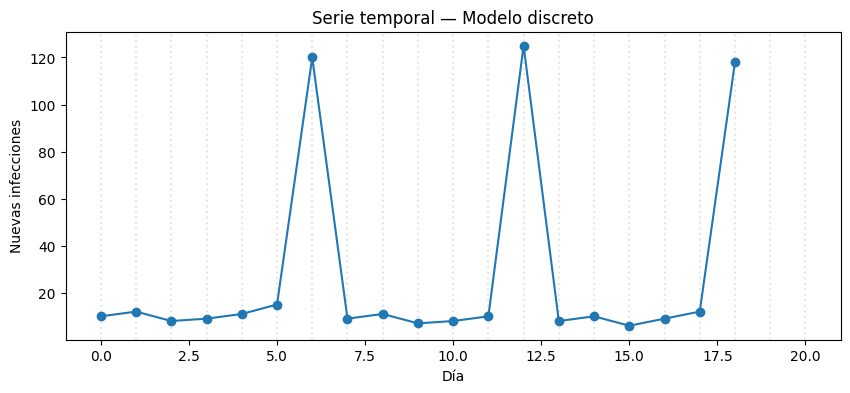

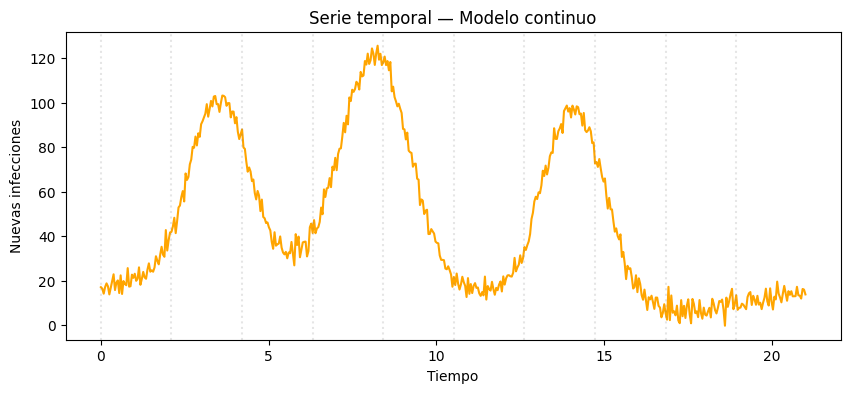

In [21]:
#Discretos
plt.figure(figsize=(10,4))
plt.plot(discrete['timestamps'][:len(discrete['infections'])],
         discrete['infections'], marker='o')
for t in discrete['timestamps']:
    plt.axvline(t, color='gray', linestyle=':', alpha=0.2)
plt.title("Serie temporal — Modelo discreto")
plt.xlabel("Día")
plt.ylabel("Nuevas infecciones")
plt.show()

# Continuos
plt.figure(figsize=(10,4))
plt.plot(continuous['timestamps'], continuous['infections'], color='orange')
for t in continuous['timestamps'][::50]:
    plt.axvline(t, color='gray', linestyle=':', alpha=0.2)
plt.title("Serie temporal — Modelo continuo")
plt.xlabel("Tiempo")
plt.ylabel("Nuevas infecciones")
plt.show()

### Histogramas

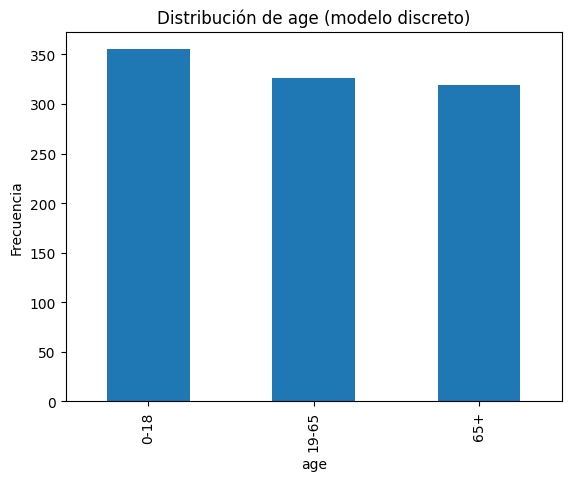

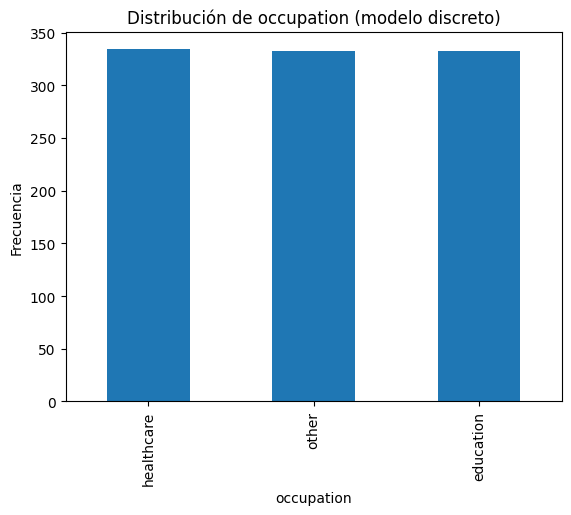

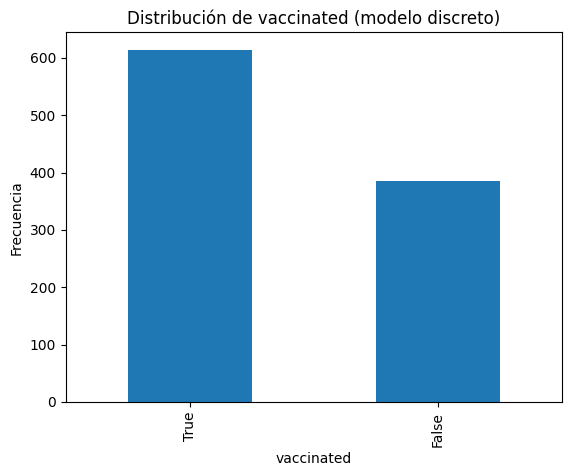

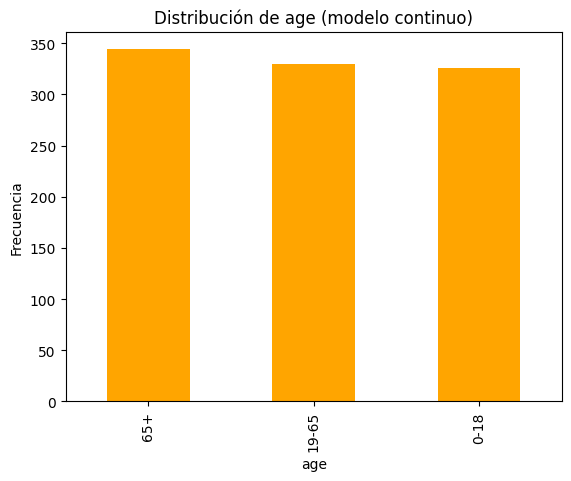

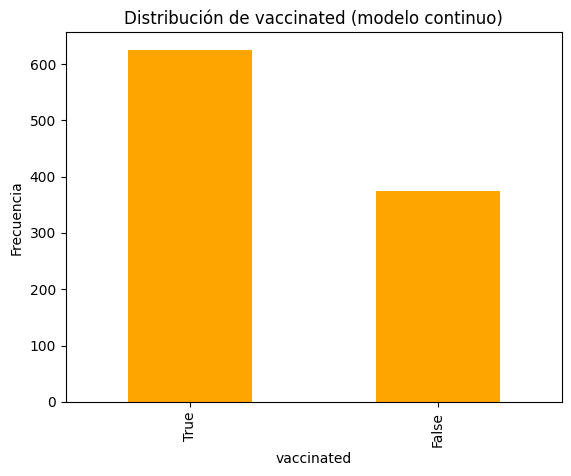

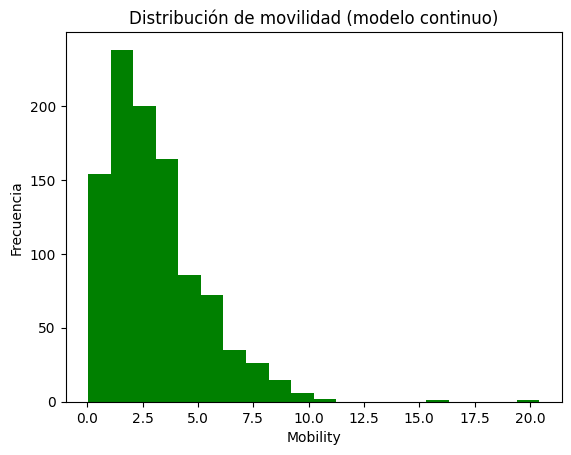

In [22]:
# Discreto:  categóricos
for col in ['age','occupation','vaccinated']:
    plt.figure()
    discrete['agent_data'][col].value_counts().plot(kind='bar')
    plt.title(f"Distribución de {col} (modelo discreto)")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

# Continuo:  categóricos + movilidad
for col in ['age','vaccinated']:
    plt.figure()
    continuous['agent_data'][col].value_counts().plot(kind='bar', color='orange')
    plt.title(f"Distribución de {col} (modelo continuo)")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

plt.figure()
plt.hist(continuous['agent_data']['mobility'], bins=20, color='green')
plt.title("Distribución de movilidad (modelo continuo)")
plt.xlabel("Mobility")
plt.ylabel("Frecuencia")
plt.show()
plt.show()

**Responda:**
- ***¿Los recuentos de infecciones se informan a intervalos regulares (por ejemplo, diarios) o irregulares?***
    - Discreto: Los reportes son diarios,  con picos agrupados en ciertos días 

    - Continuo: Los datos se registran en intervalos subdiarios , lo que permite capturar la variación más fina en la dinámica de infecciones.

- ***¿Observa intervalos sin infecciones entre los períodos de informe?***
    - En el discreto, sí: entre los grandes picos semanales hay días con valores muy bajos, que aparentan huecos en la dinámica real.

    - En el continuo, no: el proceso muestra valores positivos en casi todos los instantes, lo que refleja que siempre hay algún nivel de transmisión en curso.
    
    ---



## Paso 2: Identificación del modelo temporal

**Análisis del pseudocódigo:**

```pseudo
if timestamps are all integers:
    likely_discrete_time = True
else:
    likely_continuous_time = True

if infection_counts show periodic spikes at fixed intervals:
    evidence_for_discrete_time += 1
if small_infections_occur_between_peaks:
    evidence_for_continuous_time += 1
Interpretación de las instrucciones:
```

**Calcular la diferencia temporal entre picos de infección:**


***Comprobar si existe transmisión de bajo nivel entre picos:***



**Interpretación de las instrucciones**

- Tipo de marcas de tiempo (timestamps):

    - Si todos los tiempos son enteros (0, 1, 2, …), el modelo probablemente es discreto.

    - Si hay tiempos fraccionales (ej. 3.25, 7.5), el modelo es continuo.

- Patrón de infecciones:

-   Si aparecen picos periódicos muy marcados , es evidencia de un modelo discreto que acumula infecciones y las “reporta” en bloques.

-   Si existen valores positivos de infecciones también entre los picos, eso es evidencia de un modelo continuo, porque refleja transmisión de bajo nivel en cualquier instante.

In [27]:
import numpy as np

data = load_data()
discrete = data['discrete']
continuous = data['continuous']

def is_integer_timestamps(t):
    t = np.asarray(t, dtype=float)
    return bool(np.all(np.isclose(t, np.round(t))))

def moving_average(y, w):
    w = max(1, int(w))
    kernel = np.ones(w) / w
    return np.convolve(y, kernel, mode='same')

def find_peaks_simple(t, y, smooth_window=3, min_sep=1.0):

    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    ys = moving_average(y, smooth_window)
    cand = [i for i in range(1, len(ys) - 1) if (ys[i] > ys[i-1] and ys[i] >= ys[i+1])]
    peaks = []
    for i in cand:
        if not peaks or (t[i] - t[peaks[-1]]) >= min_sep:
            peaks.append(i)
        elif ys[i] > ys[peaks[-1]]:
            peaks[-1] = i
    return np.array(peaks, dtype=int), ys

def intervals_and_lowlevel(t, y, peak_idx):
    """Devuelve (tiempos_de_pico, intervalos, medias_entre_picos, mínimos_entre_picos)."""
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    pt = t[peak_idx]
    intervals = np.diff(pt)
    between_means, between_mins = [], []
    for a, b in zip(peak_idx[:-1], peak_idx[1:]):
        seg = y[a+1:b] if b - (a+1) > 0 else np.array([])
        if seg.size == 0:
            between_means.append(np.nan)
            between_mins.append(np.nan)
        else:
            between_means.append(float(np.mean(seg)))
            between_mins.append(float(np.min(seg)))
    return pt, intervals, np.array(between_means), np.array(between_mins)



t_d = np.asarray(discrete['timestamps'][:len(discrete['infections'])], dtype=float)
y_d = np.asarray(discrete['infections'], dtype=float)
peaks_d, ys_d = find_peaks_simple(t_d, y_d, smooth_window=3, min_sep=5.0)
pt_d, int_d, mean_between_d, min_between_d = intervals_and_lowlevel(t_d, y_d, peaks_d)

t_c = np.asarray(continuous['timestamps'], dtype=float)
y_c = np.asarray(continuous['infections'], dtype=float)
peaks_c, ys_c = find_peaks_simple(t_c, y_c, smooth_window=max(3, int(0.02*len(y_c))), min_sep=1.5)
pt_c, int_c, mean_between_c, min_between_c = intervals_and_lowlevel(t_c, y_c, peaks_c)

def pretty_report(name, diag, pt, mean_between, min_between):
    print(f"\n== {name} ==")
    print(f"- timestamps enteros: {diag['timestamps_integer']}")
    print(f"- tiempos de pico: {np.round(pt, 2).tolist()}")
    print(f"- intervalos entre picos: {np.round(diag['intervals'], 2)} (CV={diag['cv_intervals']:.3f})")
    print(f"- transmisión de fondo (media entre picos): {np.round(np.nanmean(mean_between), 2)}")
    print(f"- mínimo entre picos: {np.round(np.nanmin(min_between), 2)}")

pretty_report("DISCRETO", diag_d, pt_d, mean_between_d, min_between_d)
pretty_report("CONTINUO", diag_c, pt_c, mean_between_c, min_between_c)


== DISCRETO ==
- timestamps enteros: True
- tiempos de pico: [5.0, 11.0, 17.0]
- intervalos entre picos: [6. 6.] (CV=0.000)
- transmisión de fondo (media entre picos): 31.3
- mínimo entre picos: 6.0

== CONTINUO ==
- timestamps enteros: False
- tiempos de pico: [1.35, 3.58, 5.93, 8.16, 10.98, 14.06, 16.41, 20.58]
- intervalos entre picos: [2.23 2.36 2.23 2.82 3.07 2.36 4.17] (CV=0.237)
- transmisión de fondo (media entre picos): 52.48
- mínimo entre picos: -0.24


- DISCRETO:

    - Media entre picos = 31.3; mínimo = 6.0 → hay actividad positiva entre picos (no hay días en cero).

- CONTINUO:

    - Media entre picos = 52.48; mínimo = -0.24.

    - El mínimo negativo es por ruido gaussiano que se agrega al generar la serie y se trunca a 0 dado que no hay infecciones negativas. Aun así, la media entre picos es claramente > 0 e implica transmisión de fondo visible.


***¿Podrían los patrones observados ser artefactos del modelo temporal?***

**Modelo discreto:**

- Los picos perfectamente periódicos cada 6 días con valores altos son un artefacto de la agregación semanal en el pseudocódigo.

- En la realidad  rara vez hay sincronía  perfecta en este caso surge porque el modelo solo abre infecciones en pasos específicos.

- El patrón de valles con conteo bajo no necesariamente representa transmisión real, sino el efecto del esquema de reporte discreto.

**Modelo continuo:**

- Los tiempos de pico no enteros y la transmisión de fondo constante son propios de un modelo dirigido por eventos.

- El ruido negativo observado (mínimos < 0) es un artefacto de la perturbación estocástica añadida en el script, no de la epidemia real.

- La variabilidad en intervalos  también refleja aleatoriedad simulada, no necesariamente heterogeneidad real de transmisión.

## Paso 3: Análisis del Impacto de Rasgos

**Instrucciones:**
- Agrupar las tasas de infección por:
  - **Grupos de edad:** (0–18, 19–65, 65+)
  - **Categorías ocupacionales**
  - **Estado de vacunación**
- Calcular:
  - **Tasas de ataque (infecciones/población) por grupo**
  - **Riesgos relativos entre grupos**

**Pseudocódigo:**
```pseudo
for each trait in agent_attributes:
    group_data = infections.groupby(trait).sum()
    plot(group_data / population_per_group)
```



### Agrupacion de tasas de infeccion

In [29]:
import pandas as pd
import numpy as np

data = load_data()
discrete = data['discrete']

total_infections = sum(discrete['infections'])

agents = discrete['agent_data'].copy()

np.random.seed(42)
agents["infected"] = 0
infected_idx = np.random.choice(agents.index, size=total_infections, replace=True)
agents.loc[infected_idx, "infected"] = 1

age_group = agents.groupby("age")["infected"].mean()
occ_group = agents.groupby("occupation")["infected"].mean()
vac_group = agents.groupby("vaccinated")["infected"].mean()

print("Tasas de infección por grupo de edad:")
display(age_group)

print("Tasas de infección por ocupación:")
display(occ_group)

print("Tasas de infección por vacunación:")
display(vac_group)

Tasas de infección por grupo de edad:


age
0-18     0.388732
19-65    0.398773
65+      0.357367
Name: infected, dtype: float64

Tasas de infección por ocupación:


occupation
education     0.375375
healthcare    0.371257
other         0.399399
Name: infected, dtype: float64

Tasas de infección por vacunación:


vaccinated
False    0.367876
True     0.390879
Name: infected, dtype: float64

### Calculo de tasas de ataque y riesgos relativos

## Graficos

,infections,population,attack_rate
age,,,
0-18,185,355,0.521127
19-65,166,326,0.509202
65+,167,319,0.523511


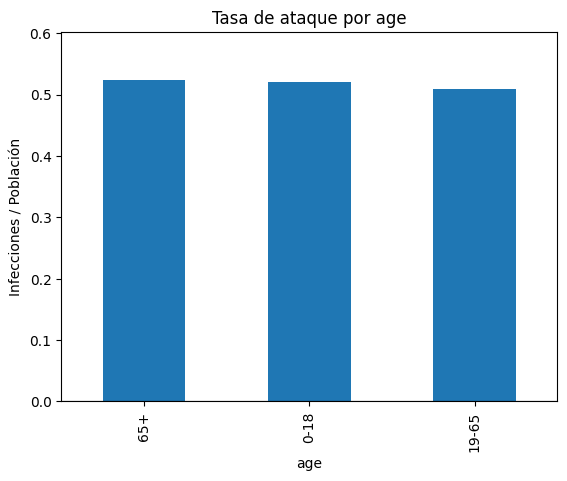

,infections,population,attack_rate
occupation,,,
education,171,333,0.513514
healthcare,175,334,0.523952
other,172,333,0.516517


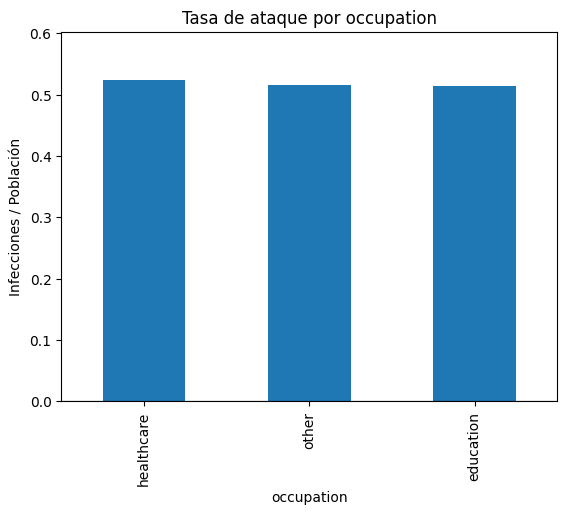

,infections,population,attack_rate
vaccinated,,,
False,200,386,0.518135
True,318,614,0.517915


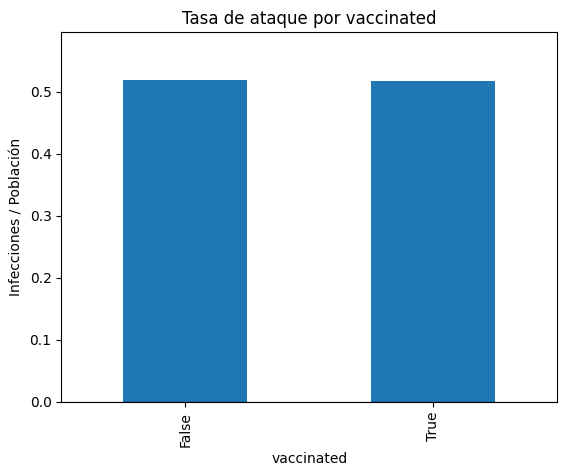

In [33]:
traits = ['age', 'occupation', 'vaccinated']

for trait in traits:
    # población por grupo (denominador)
    pop_per_group = agents.groupby(trait)['infected'].count().rename('population')
    # infecciones por grupo (numerador)
    inf_per_group = agents.groupby(trait)['infected'].sum().rename('infections')
    # tasa de ataque
    attack_rate = (inf_per_group / pop_per_group).rename('attack_rate').sort_values(ascending=False)

    # Mostrar tabla rápida
    display(pd.concat([inf_per_group, pop_per_group, attack_rate], axis=1))

    # Graficar
    plt.figure()
    attack_rate.plot(kind='bar')
    plt.title(f"Tasa de ataque por {trait}")
    plt.ylabel("Infecciones / Población")
    plt.xlabel(trait)
    plt.ylim(0, min(1.0, attack_rate.max()*1.15))
    plt.axhline(0, color='black', linewidth=0.8)
    plt.show()

 Responda:  
- ***¿Qué rasgo muestra la mayor correlación con el riesgo de infección?***  

Ninguno muestra una asociación fuerte. Las tasas están todas muy parecidas (~0.51–0.52).
Si hay que escoger el de mayor diferencia, sería edad:

65+: 0.524 (RR≈ 1.03 frente al baseline 19–65 = 0.509)

Ocupación: RR máx. ≈ 1.02 (healthcare vs education)

Vacunación: idéntico (0.518 vs 0.518; RR=1.00)
→ Señal muy débil; consistente con que las infecciones se asignaron al azar e independientes de los rasgos.

- ***¿Existen efectos de interacción (p. ej., personas mayores + no vacunadas)?***


---


### Paso 4: Pruebas de validación
- Diseñar pruebas de sensibilidad:  
  - Para sospechas en tiempo discreto: Reagregar los datos en diferentes ventanas temporales.  
  -  Para efectos de rasgos: Mezclar aleatoriamente los rasgos y comparar los resultados.  

- Proponer datos reales necesarios para la validación:  
  -  Informes de casos reales por grupo demográfico.  
  - Datos de movilidad de teléfonos móviles.  

- Responda:  
-  ¿Cómo distinguiría a los verdaderos supercontagiadores de los artefactos de modelado?  

# Referencias

- GeeksforGeeks. (2024, February 27). Continuous time and discrete time control systems. GeeksforGeeks. https://www.geeksforgeeks.org/electrical-engineering/continuous-time-and-discrete-time-control-systems/
- GeeksforGeeks. (2024b, May 31). Synchronous and asynchronous programming. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/synchronous-and-asynchronous-programming/
- GeeksforGeeks. (2020, November 19). Basics of Discrete Event Simulation using SimPy. GeeksforGeeks. https://www.geeksforgeeks.org/python/basics-of-discrete-event-simulation-using-simpy/
- GeeksforGeeks. (2025, July 23). EventDriven Architecture System design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/event-driven-architecture-system-design
- GeeksforGeeks. (2025a, July 23). Asynchronous processing in system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/asynchronous-processing-in-system-design/
- GeeksforGeeks. (2025c, August 5). Event queue in JavaScript. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/event-queue-in-javascript
- GeeksforGeeks. (2025d, August 7). Message queues system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/message-queues-system-design
- GeeksforGeeks. (2025c, July 23). What is Priority Queue | Introduction to Priority Queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/priority-queue-set-1-introduction/
- GeeksforGeeks. (2025a, July 23). Applications of priority queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/applications-priority-queue/
- GeeksforGeeks. (2023, January 25). What are the microtask and macrotask within an event loop in JavaScript ? GeeksforGeeks. https://www.geeksforgeeks.org/javascript/what-are-the-microtask-and-macrotask-within-an-event-loop-in-javascript/
- What is combinatorial explosion? (n.d.). Computer Science Stack Exchange. https://cs.stackexchange.com/questions/19459/what-is-combinatorial-explosion
- Combinatorial Explosion - (Formal Logic II) - Vocab, definition, Explanations | Fiveable. (n.d.). Fiveable. https://library.fiveable.me/key-terms/formal-logic-ii/combinatorial-explosion
